In [1]:
import os
import numpy as np
from PIL import Image

def load_images_from_folder(base_path):
    datasets = {'healthy': {'images': [], 'labels': []},
                'parkinson': {'images': [], 'labels': []}}
    
    for dataset in ['testing', 'training']:
        dataset_path = os.path.join(base_path, 'spiral', dataset)
        
        for class_label, class_folder in enumerate(['healthy', 'parkinson']):
            class_path = os.path.join(dataset_path, class_folder)
            
            if os.path.isdir(class_path):
                for filename in os.listdir(class_path):
                    img_path = os.path.join(class_path, filename)
                    
                    try:
                        with Image.open(img_path) as img:
                            img = img.convert('RGB')
                            img = img.resize((224, 224))  # Adjust size as needed
                            img_array = np.array(img)
                            datasets[class_folder]['images'].append(img_array)
                            datasets[class_folder]['labels'].append(class_label)
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
    
    # Convert lists to numpy arrays
    for dataset in datasets:
        datasets[dataset]['images'] = np.array(datasets[dataset]['images'])
        datasets[dataset]['labels'] = np.array(datasets[dataset]['labels'])
    
    return datasets

# Usage
base_path = 'D:\Projects\Parkinsons_disease\image_model\data'
datasets = load_images_from_folder(base_path)

# Access healthy and parkinson data separately
X_healthy, y_healthy = datasets['healthy']['images'], datasets['healthy']['labels']
X_parkinson, y_parkinson = datasets['parkinson']['images'], datasets['parkinson']['labels']

print(f"Loaded {len(X_healthy)} healthy images and {len(X_parkinson)} parkinson images")
print(f"Image shape: {X_healthy[0].shape}")
print(f"Number of classes: {len(np.unique(np.concatenate([y_healthy, y_parkinson])))}")

Loaded 51 healthy images and 51 parkinson images
Image shape: (224, 224, 3)
Number of classes: 2


In [2]:
import glob
# import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [3]:
X_healthy.shape

(51, 224, 224, 3)

In [4]:
from skimage.transform import resize

In [5]:
target_shape = (51, 112, 112, 3)

# Resize the array
resized_array = resize(X_healthy, target_shape, anti_aliasing=True)

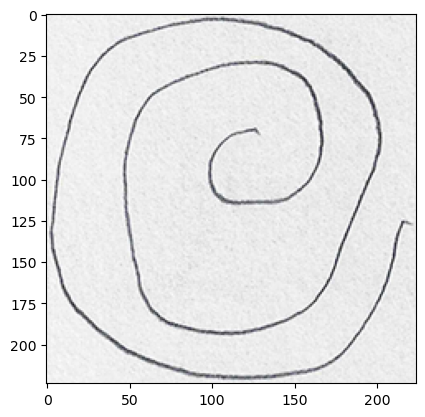

In [6]:
plt.imshow(X_healthy[0])

In [7]:
X_healthy.shape

(51, 224, 224, 3)

In [8]:
X_parkinson.shape

(51, 224, 224, 3)

In [9]:
y_healthy.shape

(51,)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
XX_healthy_train,X_healthy_test, yy_healthy_train,y_healthy_test = train_test_split(X_healthy,y_healthy,random_state=0,test_size=0.3)

In [12]:
X_healthy_train,X_healhty_val,y_healthy_train,y_healthy_val = train_test_split(XX_healthy_train,yy_healthy_train,test_size=0.1,random_state=0)

In [13]:
print(f"train: {X_healthy_train.shape} {y_healthy_train.shape}")
print(f"val: {X_healhty_val.shape} {y_healthy_val.shape}")
print(f"test: {X_healthy_test.shape} {y_healthy_test.shape}")

train: (31, 224, 224, 3) (31,)
val: (4, 224, 224, 3) (4,)
test: (16, 224, 224, 3) (16,)


In [14]:
from tensorflow.keras.applications import ResNet152
import tensorflow as tf
healthy_model = ResNet152(weights='imagenet',include_top=False)
x = healthy_model.output
healthy_embedding = tf.keras.layers.Flatten()(x)

In [15]:
# healthy_embedding.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

In [16]:
healthy_embedding_model = tf.keras.models.Model(inputs=healthy_model.input, outputs=healthy_embedding)


In [17]:
h_train_embed = healthy_embedding_model.predict(X_healthy_train)

1/1 [==============================] - 6s 6s/step


In [18]:
h_train_embed.shape

(31, 100352)

Healthy training data embeddings saved as h_train_embed

In [19]:
X_parkinson.shape

(51, 224, 224, 3)

In [20]:
y_parkinson.shape

(51,)

In [21]:
XX_parkinson_train, X_parkinson_test, yy_parkinson_train,y_parkinson_test = train_test_split(X_parkinson,y_parkinson,random_state=0,test_size=0.3)

In [22]:
X_parkinson_train, X_parkinson_val,y_parkinson_train,y_parkinson_val = train_test_split(XX_parkinson_train,yy_parkinson_train,test_size=0.1,random_state=0)

In [23]:
print(f"train: {X_parkinson_train.shape} {y_parkinson_train.shape}")
print(f"val: {X_parkinson_val.shape} {y_parkinson_val.shape}")
print(f"test: {X_parkinson_test.shape} {y_parkinson_test.shape}")

train: (31, 224, 224, 3) (31,)
val: (4, 224, 224, 3) (4,)
test: (16, 224, 224, 3) (16,)


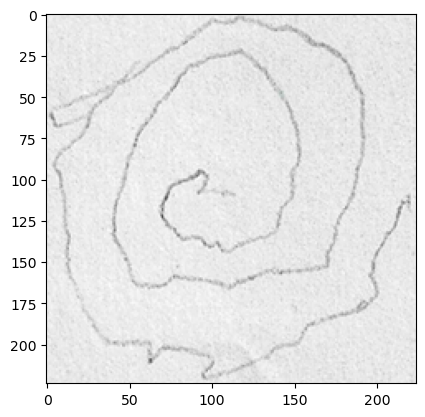

In [24]:
plt.imshow(X_parkinson_train[0])

In [25]:
parkinson_model = ResNet152(weights='imagenet',include_top=False)
x = parkinson_model.output
parkinson_embedding = tf.keras.layers.Flatten()(x)
parkinson_embedding_model = tf.keras.models.Model(inputs=parkinson_model.input, outputs=parkinson_embedding)


In [26]:
p_train_embed = parkinson_embedding_model.predict(X_parkinson_train)

1/1 [==============================] - 6s 6s/step


In [27]:
p_train_embed.shape

(31, 100352)

In [28]:
np.save('healthy_embeddings.npy', h_train_embed)
np.save('parkinson_embeddings.npy', p_train_embed)

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

# Load saved embeddings
embeddings_A = np.load('healthy_embeddings.npy')
embeddings_B = np.load('parkinson_embeddings.npy')

def classify_image(image):
    embedding_A = healthy_embedding_model.predict(np.expand_dims(image, axis=0))
    embedding_B = parkinson_embedding_model.predict(np.expand_dims(image, axis=0))
    
    # Compute similarity scores
    sim_A = np.max(cosine_similarity(embedding_A, embeddings_A))
    sim_B = np.max(cosine_similarity(embedding_B, embeddings_B))
    
    if sim_A > sim_B:
        return 'healthy'
    else:
        return 'parkinson'

In [30]:
classified_label = classify_image(X_healthy_test[1])
print(classified_label)

1/1 [==============================] - 0s 288ms/step
healthy


In [31]:
classified_label = classify_image(X_parkinson_test[1])
print(classified_label)

1/1 [==============================] - 0s 244ms/step
parkinson


In [32]:
def accuracy_score():
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    misclassified_healthy = []
    misclassified_parkinson = []
    for i in range(0,X_healthy_test.shape[0]):
        if classify_image(X_healthy_test[i]) == 'healthy':
            TP+=1
        else:
            FP+=1
            misclassified_healthy.append(i)
    for i in range(0,X_parkinson_test.shape[0]):
        if classify_image(X_parkinson_test[i])=='parkinson':
            TN+=1
        else:
            FN+=1
            misclassified_parkinson.append(i)
    return [TP,TN,FP,FN,misclassified_healthy,misclassified_parkinson]

In [33]:
[TP,TN,FP,FN,misclassified_healthy,misclassified_parkinson] = accuracy_score()

1/1 [==============================] - 0s 226ms/step


In [34]:
print(f"TP: {TP}")
print(f"FP: {FP}")
print(f"TN: {TN}")
print(f"FN: {FN}")

TP: 15
FP: 1
TN: 14
FN: 2


In [35]:
import seaborn as sns

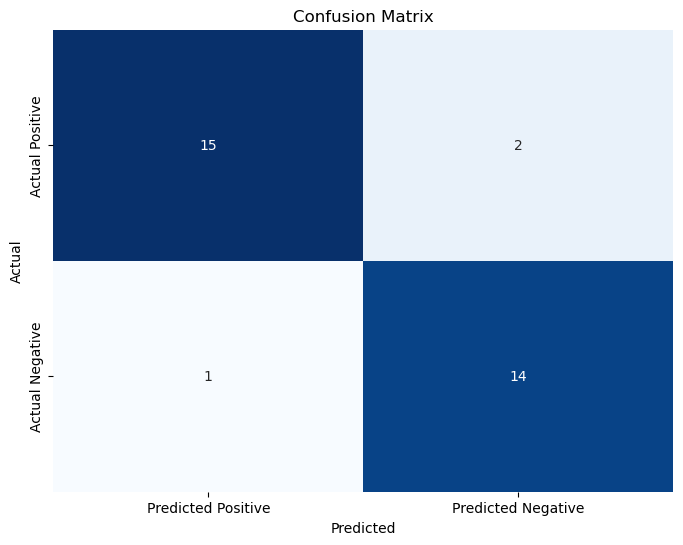

In [36]:
confusion_matrix = np.array([[TP, FN],
                                 [FP, TN]])
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Positive', 'Predicted Negative'],
                yticklabels=['Actual Positive', 'Actual Negative'])
    
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

verifying misclassified images

In [37]:
misclassified_healthy

[4]

In [38]:
misclassified_parkinson

[0, 11]

actual: healhty, classified: parkinson


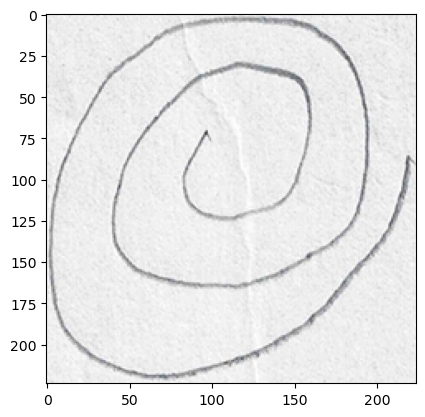

In [39]:
plt.imshow(X_healthy_test[misclassified_healthy[0]])
print("actual: healhty, classified: parkinson")

actual: parkinson, classified healthy


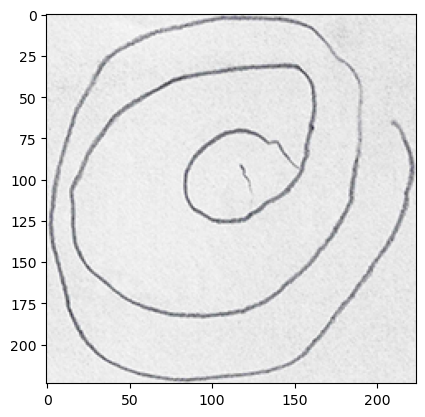

In [40]:
plt.imshow(X_parkinson_test[misclassified_parkinson[0]])
print("actual: parkinson, classified healthy")

actual: parkinson, classified healthy


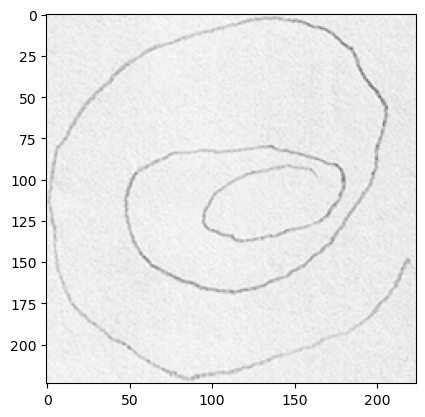

In [41]:
plt.imshow(X_parkinson_test[misclassified_parkinson[1]])
print("actual: parkinson, classified healthy")

In [42]:
XX_healthy_train.shape

(35, 224, 224, 3)